# Import

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors

import torch
from torch import FloatTensor, LongTensor
import math

In [2]:
from load_script_deep_framework import load_dataset

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
'Dataset plotting function'
def plot_output(train, all_output, permutation):
    plt.figure(figsize=(3,3))
    plt.scatter(train[permutation][:,0], train[permutation][:,1], c = all_output)

# Loading the dataset

In [5]:
train,target_train = load_dataset()

In [6]:
test,target_test = load_dataset()

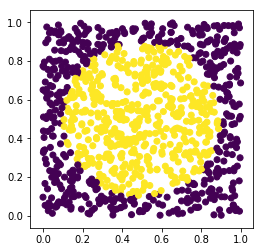

In [7]:
plt.figure(figsize=(4,4))
plt.scatter(test[:,0], test[:,1], c=target_test[:,1].numpy())
plt.show()

# Generic Module Class

In [26]:
class Module():
    '''General class structure from which to inherit'''
    def forward(self,input):
        raise NotImplemented
        
    def backward(self,input):
        raise NotImplemented
            
    def param(self):
        return []
    
    def __call__(self, *input):
        return self.forward(*input)
    
    def zero_grad_(self):
        return
    
    def update_weights_(self, learning_rate):
        return

# Specific classes

In [9]:
class Linear(Module):
    '''Linear layer implementation, needs the number of inputs and number of units to call an instance.
    It initializes Gaussian weights with mean = 0 and std = 0.1.
    Bias terms are included in the weights matrix.'''
    def __init__(self, input_dimension, output_dimension):
        super(Linear,self).__init__()
        
        self._input_dimension = input_dimension
        self._output_dimension = output_dimension
    
        self._weights = torch.randn(self._output_dimension, self._input_dimension + 1)*1e-1

        self._gradient = torch.zeros(self._weights.shape)
    
    def forward(self, input):
        
        # Append '1' to input to be multiplied to bias term
        self._input = torch.cat((torch.Tensor([1]), input.view(-1)))
        
        self._output = self._weights.mv(self._input)
        
        return self._output.clone()
        
    def backward(self, d_dy):
        self._gradient.add_(d_dy.view(-1,1) * self._input.view(1,-1))
        
        # Narrowing is done to exclude bias terms in backprop.
        d_dx = self._weights.narrow(1, 1, self._input_dimension).t().mv(d_dy)
        
        return d_dx
    
    def param(self):
        return [self._weights, self._gradient]
    
    def zero_grad_(self):
        self._gradient.zero_()
        
    def update_weights_(self, learning_rate):
        self._weights.add_(- learning_rate * self._gradient)
    

In [10]:
class ReLU(Module):
    '''ReLU activation function class, it performs backward and forward pass.'''
    def __init__(self):
        super(ReLU,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.clone()
        self._output[self._output < 0] = 0

        return self._output.clone()
    
    def backward(self,d_dy):
        d_dx = d_dy.clone()
        d_dx[self._input < 0] = 0
        
        return d_dx
        

In [11]:
class Tanh(Module):
        '''Tanh activation function class, it performs backward and forward pass.'''
    def __init__(self):
        super(Tanh,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.tanh()
        
        return self._output.clone()
    
    def backward(self,d_dy):
        d_dx= (1 - self._input.tanh()**2) * d_dy
        
        return d_dx
        

In [12]:
class LossMSE(Module):
    def __init__(self):
        super(LossMSE,self).__init__()
        
    def forward(self, input, target):
        #'''Returns square error between input and target'''
        self._input = input - target
        self._output = (self._input).pow(2).sum()
        return self._output
        
    def backward(self):
        d_dy = 2 * self._input
        return d_dy

In [56]:
class OptimSGD():
    def __init__(self,sequential,learning_rate,decay_rate=1):
        super(OptimSGD,self).__init__()
        
        self._learning_rate = learning_rate
        self._sequential= sequential
        self._decay_rate = decay_rate
    
    def step(self):
        
        for param_grad in self._sequential.param():
            if param_grad:
                param_grad[0].add_(- self._learning_rate * param_grad[1]) 
        
    
    def zero_grad_(self):
        
        for param_grad in self._sequential.param():
            if param_grad:
                param_grad[1].zero_()
        
    def learning_decay(self):
        self._learning_rate *= self._decay_rate
        
        

In [51]:
class Sequential(Module):
    '''Builds a neural network, takes a list of layers and activation functions + loss function when instantiated.
    Performs the forward pass for the input through all the layers and returns loss.
    Similarly performs backward pass.
    zero_grad and update_weights_ allow to modify network parameters.'''
    
    def __init__(self, modules ,loss):
        super(Sequential,self).__init__()
        
        self._modules = modules
        self._loss = loss
    
    def forward(self, input, target):
        
        y = input.clone()
        for module in self._modules:
            y = module(y)
        
        output = y.clone()
        
        loss = self._loss(y, target)
        
        return loss, output
    
    def backward(self):
        d_dy = self._loss.backward()
        
        for module in reversed(self._modules):
            d_dy = module.backward(d_dy)
            
            
    def zero_grad_(self):
        for module in self._modules:
            module.zero_grad_()
    
    
    def param(self):
        param_list=[]
        for module in self._modules:
            if module.param():
                param_list.append(module.param())
        return param_list

    def update_weights_(self,learning_rate):
        for module in self._modules:
            module.update_weights_(learning_rate)

In [57]:
# Define the Neural Network
layers = [
    Linear(2,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,2),
    Tanh()
]
loss_function = LossMSE()
network = Sequential(layers, loss_function)

# Initial learning rate
learning_rate = 5e-2
decay_rate =0.95

optimizer=OptimSGD(network, learning_rate, decay_rate)

num_epochs = 200

# Initialize lists to store training loss and test accuracy
train_loss = []
test_correct = []

# Define subplot for dataset visualization
fig, axes = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True, figsize = (9, 6))
ind = 0

for epoch in range(num_epochs):
    
    correct = 0
    all_output = []
    loss_sum = 0
    
    # Randomize order for SGD
    permutation = torch.randperm(target_train.shape[0])

    for j, pair in enumerate(zip(train[permutation],target_train[permutation])):
        
        # Load sample
        train_element, target_element = pair
        
        # Forward pass
        loss, output = network(train_element, target_element)
        loss_sum += loss

        # Backward pass, gradient step and reinitalize gradient
        network.backward()
        #network.update_weights_(learning_rate)
        optimizer.step()
        optimizer.zero_grad_()

        # Training error
        boolean_target = target_element[1] > target_element[0]
        boolean_output = output[1] > output[0]
        
        all_output.append(output.numpy().tolist()[1])
        
        if boolean_target == boolean_output:
            correct += 1
        
    train_loss.append(loss_sum/1000)
    optimizer.learning_decay()
    
    if epoch % 1 == 0:
        print('Epoch: {}. Train error: {} %. Loss: {}.'.format(epoch ,(1000-correct)/1000*100, loss_sum/1000))
        
        test_correct.append(test_error())
        
    if epoch in [1, 10, 15, 25, 100, 499]:
        axes[ind // 3, ind % 3].scatter(train[permutation][:,0], train[permutation][:,1], c = all_output)
        ind += 1

Epoch: 0. Train error: 52.2 %. Loss: 2.1252729395926.
Test error 51.6 %
Epoch: 1. Train error: 51.9 %. Loss: 2.1175082145780326.
Test error 48.4 %
Epoch: 2. Train error: 48.4 %. Loss: 2.0573114164215514.
Test error 48.4 %
Epoch: 3. Train error: 44.6 %. Loss: 1.9493444769003774.
Test error 48.4 %
Epoch: 4. Train error: 43.5 %. Loss: 1.898405955888737.
Test error 48.4 %
Epoch: 5. Train error: 44.0 %. Loss: 1.881198707400875.
Test error 44.6 %
Epoch: 6. Train error: 42.0 %. Loss: 1.8644536868574737.
Test error 44.3 %
Epoch: 7. Train error: 44.4 %. Loss: 1.9100548040579213.
Test error 40.8 %
Epoch: 8. Train error: 41.099999999999994 %. Loss: 1.8583819623330042.
Test error 40.8 %
Epoch: 9. Train error: 41.199999999999996 %. Loss: 1.862750786297874.
Test error 43.2 %
Epoch: 10. Train error: 40.1 %. Loss: 1.8275543220235986.
Test error 41.199999999999996 %
Epoch: 11. Train error: 40.699999999999996 %. Loss: 1.8203304648825576.
Test error 41.199999999999996 %
Epoch: 12. Train error: 32.4 %. Lo

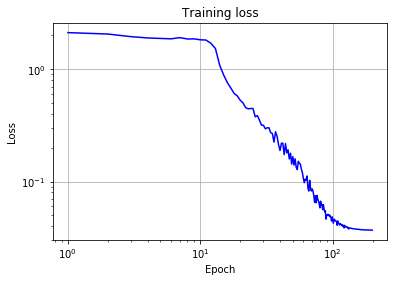

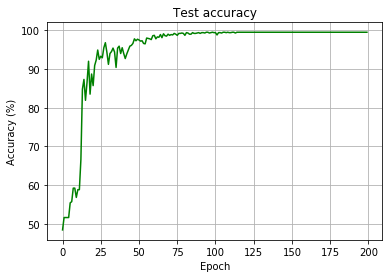

In [60]:
plt.figure("Train Loss")
plt.title("Training loss")
plt.loglog(train_loss, 'b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()
#plt.savefig("figures/loss_loglog.eps", format="eps")

plt.figure("Test accuracy")
plt.title("Test accuracy")
plt.plot([100-i for i in test_correct], 'green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()
#plt.savefig("figures/accuracy.eps", format="eps")

# Test

In [32]:
def test_error():
    correct_test = 0

    for j, pair in enumerate(zip(test,target_test)):

        # Load test sample
        test_element, target_test_element = pair

        # Forward pass
        loss, output = network(test_element, target_test_element)

        boolean_target = target_test_element[1] > target_test_element[0]

        boolean_output = output[1] > output[0]

        if boolean_target == boolean_output:
            correct_test += 1 

    correct_test = (1000-correct_test)/1000 * 100
    print('Test error {} %'.format(correct_test))
    
    return correct_test